In [53]:
from __future__ import annotations
import jijmodeling as jm
import jijmodeling_transpiler as jmt
import jijmodeling_transpiler_quantum.quri_parts as jq_qu

from quri_parts.qulacs.estimator import (
    create_qulacs_vector_parametric_estimator,
)
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.circuit import (
    LinearMappedUnboundParametricQuantumCircuit,
    Parameter,
)
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.operator import Operator, pauli_label

from scipy.optimize import minimize, OptimizeResult

import numpy as np
import matplotlib.pyplot as plt

In [54]:
def tsp():

    # define variables
    d = jm.Placeholder("d", ndim=2)
    N = d.len_at(0, latex="N")
    i = jm.Element("i", belong_to=(0, N))  # city index
    j = jm.Element("j", belong_to=(0, N))  # city index
    t = jm.Element("t", belong_to=(0, N))  # time index or step index
    x = jm.BinaryVar("x", shape=(N, N))

    # set problem
    problem = jm.Problem("TSP")
    problem += jm.sum([i, j], d[i, j] * jm.sum(t, x[i, t] * x[j, (t + 1) % N]))
    problem += jm.Constraint("one-city", jm.sum(i, x[i, t]) == 1, forall=t)
    problem += jm.Constraint("one-time", jm.sum(t, x[i, t]) == 1, forall=i)
    problem
    return problem


def plot_instance(x_pos: np.ndarray, y_pos: np.ndarray):
    plt.plot(x_pos[0], y_pos[0], "o", color="red")
    plt.plot(x_pos[1:], y_pos[1:], "o", color="blue")
    plt.show()

In [55]:
def generate_random_instance(n):
    x_pos = np.random.rand(n)
    y_pos = np.random.rand(n)
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2)
    return x_pos, y_pos, distance

In [56]:
x_pos, y_pos, distance = generate_random_instance(4)

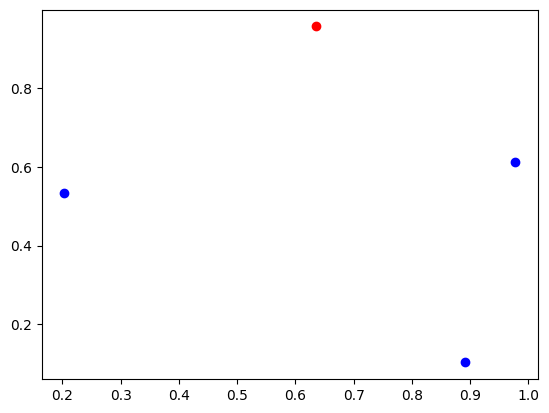

In [57]:
plot_instance(x_pos, y_pos)

In [58]:
compiled_instance = jmt.core.compile_model(tsp(), {"d": distance})

In [59]:
qaoa_builder = jq_qu.transpile_to_qaoa_ansatz(compiled_instance, relax_method = jmt.core.pubo.RelaxationMethod.SquaredPenalty)

# You can also use Augumented Lagrangian method to build QUBO
# qaoa_builder = transpile_to_qaoa_ansatz(compiled_instance, relax_method = jmt.core.pubo.RelaxationMethod.AugmentedLagrangian)

In [60]:
ising_operator, constant= qaoa_builder.get_hamiltonian(multipliers = {'one-city':1,'one-time':1})

In [61]:
qaoa_ansatz, hamiltonian, constant = qaoa_builder.get_qaoa_ansatz(p=1,multipliers = {'one-city':1,'one-time':1})

In [62]:
print("Qubit count:", qaoa_ansatz.qubit_count)
print("Circuit depth:", qaoa_ansatz.depth)

# A parametric circuit object does not have .gates property.

print("Parameter count:", qaoa_ansatz.parameter_count)


Qubit count: 16
Circuit depth: 23
Parameter count: 2


Now that the qiskit QAOA circuit has been obtained, programming can be carried out using qiskit from this point onwards.

# Run QAOA

In [63]:
def run_qaoa_with_log(
    ansatz: LinearMappedUnboundParametricQuantumCircuit,
    hamiltonian: Operator,
    method: str | callable,
) -> tuple[OptimizeResult, list[float]]:
    def _cost_func(parameters, ansatz, hamiltonian, estimator):
        parametric_state = ParametricCircuitQuantumState(
            ansatz.qubit_count, ansatz
        )
        estimate = estimator(hamiltonian, parametric_state, parameters)
        return estimate.value.real

    initial_params = np.array([1.0] * ansatz.parameter_count)

    estimator = create_qulacs_vector_parametric_estimator()
    optimization_history: list[float] = []

    result = minimize(
        _cost_func,
        initial_params,
        args=(ansatz, hamiltonian, estimator),
        method=method,
        callback=lambda x: optimization_history.append(
            _cost_func(x, ansatz, hamiltonian, estimator)
        ),
    )

    return result, optimization_history

In [64]:
result,optimization_history = run_qaoa_with_log(qaoa_ansatz, hamiltonian, "COBYLA")

Text(0, 0.5, 'cost function')

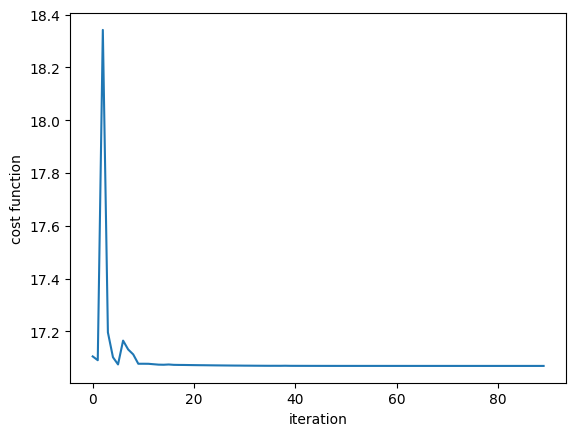

In [65]:
plt.plot(optimization_history)
plt.xlabel('iteration')
plt.ylabel('cost function')

In [66]:
def sample_result(
    result: OptimizeResult,
    ansatz: LinearMappedUnboundParametricQuantumCircuit,
    num_qubits: int,
    num_shots: int = 1000,
) -> jm.SampleSet:
    bind_ansatz_opt = ansatz.bind_parameters(result.x)
    sampler = create_qulacs_vector_sampler()
    sampling_result = sampler(bind_ansatz_opt, num_shots)
    result_bits = {
        bin(key)[2:].zfill(num_qubits)[::-1]: val
        for key, val in sampling_result.items()
    }
    sampleset = qaoa_builder.decode_from_counts(result_bits)
    return sampleset

In [67]:
sampleset = sample_result(result, qaoa_ansatz, qaoa_ansatz.qubit_count)

In [68]:
def sampleset_to_tour(sampleset: jm.SampleSet) -> list[list[int]]:
    data = sampleset.feasible().record.solution

    if data:
        tours = []
        for indices, val, shape in data["x"]:
            tour, _ = zip(*sorted(zip(*indices), key=lambda x: x[1]))
            tours.append(list(tour))
        return tours
    else:
        return []

In [69]:
tours = sampleset_to_tour(sampleset)
tours

[[2, 1, 0, 3], [3, 0, 1, 2]]

In [70]:
def plot_tour(tour: list[int], x_pos: np.ndarray, y_pos: np.ndarray):
    _tour = tour + [tour[0]]
    _tour = np.array(_tour)
    plt.plot(
            x_pos[_tour],
            y_pos[_tour],
            "o-",
            color="blue",
        )
        
    plt.plot(x_pos[0], y_pos[0], "o", color="red")
    plt.plot(x_pos[1:], y_pos[1:], "o", color="blue")
    plt.show()

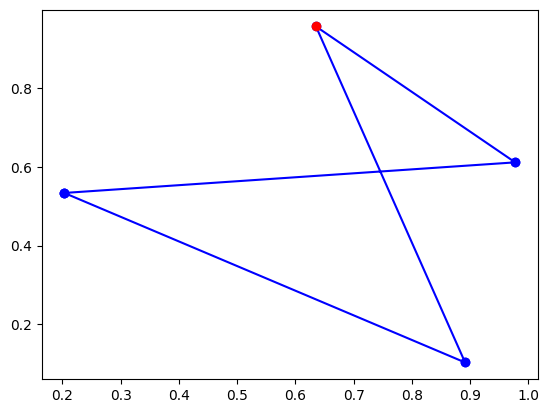

In [73]:
plot_tour(tours[0], x_pos, y_pos)